```Python
Solves the incompressible Navier Stokes equations in a lid-driven cavity
scenario using Finite Differences, explicit timestepping and Chorin's Projection.

Momentum:           ∂u/∂t + (u ⋅ ∇) u = − 1/ρ ∇p + ν ∇²u + f

Incompressibility:  ∇ ⋅ u = 0


u:  Velocity (2d vector)
p:  Pressure
f:  Forcing (here =0)
ν:  Kinematic Viscosity
ρ:  Density
t:  Time
∇:  Nabla operator (defining nonlinear convection, gradient and divergence)
∇²: Laplace Operator

----

Lid-Driven Cavity Scenario:


                            ------>>>>> u_top

          1 +-------------------------------------------------+
            |                                                 |
            |             *                      *            |
            |          *           *    *    *                |
        0.8 |                                                 |
            |                                 *               |
            |     *       *                                   |
            |                      *     *                    |
        0.6 |                                            *    |
u = 0       |      *                             *            |   u = 0
v = 0       |                             *                   |   v = 0
            |                     *                           |
            |           *                *         *          |
        0.4 |                                                 |
            |                                                 |
            |      *            *             *               |
            |           *                             *       |
        0.2 |                       *           *             |
            |                               *                 |
            |  *          *      *                 *       *  |
            |                            *                    |
          0 +-------------------------------------------------+
            0        0.2       0.4       0.6       0.8        1

                                    u = 0
                                    v = 0

* Velocity and pressure have zero initial condition.
* Homogeneous Dirichlet Boundary Conditions everywhere except for horizontal
  velocity at top. It is driven by an external flow.

-----

Solution strategy:   (Projection Method: Chorin's Splitting)

1. Solve Momentum equation without pressure gradient for tentative velocity
   (with given Boundary Conditions)

    ∂u/∂t + (u ⋅ ∇) u = ν ∇²u

2. Solve pressure poisson equation for pressure at next point in time
   (with homogeneous Neumann Boundary Conditions everywhere except for
   the top, where it is homogeneous Dirichlet)

    ∇²p = ρ/Δt ∇ ⋅ u           

3. Correct the velocities (and again enforce the Velocity Boundary Conditions)

    u ← u − Δt/ρ ∇ p

-----

    Expected Outcome: After some time a swirling motion will take place

          1 +-------------------------------------------------+
            |                                                 |
            |                                                 |
            |                                                 |
        0.8 |                                                 |
            |                      *-->*                      |
            |                ******     ******                |
            |              **                 **              |
        0.6 |             *                     *             |
            |             *                      *            |
            |            *                        *           |
            |            *                       *            |
            |             *                     *             |
        0.4 |             *                     *             |
            |              **                 **              |
            |                ******     ******                |
            |                      *<--*                      |
        0.2 |                                                 |
            |                                                 |
            |                                                 |
            |                                                 |
          0 +-------------------------------------------------+
            0        0.2       0.4       0.6       0.8        1

------

Strategy in index notation

u = [u, v]
x = [x, y]

1. Solve tentative velocity + velocity BC

    ∂u/∂t + u ∂u/∂x + v ∂u/∂y = ν ∂²u/∂x² + ν ∂²u/∂y²

    ∂v/∂t + u ∂v/∂x + v ∂v/∂y = ν ∂²v/∂x² + ν ∂²v/∂y²

2. Solve pressure poisson + pressure BC

    ∂²p/∂x² + ∂²p/∂y² = ρ/Δt (∂u/∂x + ∂v/∂y)

3. Correct velocity + velocity BC

    u ← u − Δt/ρ ∂p/∂x

    v ← v − Δt/ρ ∂p/∂y

------
IMPORTANT: Take care to select a timestep that ensures stability
```

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [93]:
N_POINTS = 101
DOMAIN_SIZE = 1.0
N_ITERATIONS = 2000
TIME_STEP_LENGTH = 0.0001
KINEMATIC_VISCOSITY = 0.1
DENSITY = 1.0
HORIZONTAL_VELOCITY_TOP = 1.0

N_PRESSURE_POISSON_ITERATIONS = 100
STABILITY_SAFETY_FACTOR = 0.5

In [94]:
element_length = DOMAIN_SIZE / (N_POINTS - 1)
x = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)
y = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)

X, Y = np.meshgrid(x, y)

u_prev = np.zeros_like(X)
v_prev = np.zeros_like(X)
p_prev = np.zeros_like(X)

In [95]:
def central_difference_x(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (
        f[1:-1, 2:  ]
        -
        f[1:-1, 0:-2]
    ) / (
        2 * element_length
    )
    return diff

In [96]:
def central_difference_y(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (
        f[2:  , 1:-1]
        -
        f[0:-2, 1:-1]
    ) / (
        2 * element_length
    )
    return diff

In [97]:
def laplace(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (
        f[1:-1, 0:-2]
        +
        f[0:-2, 1:-1]
        -
        4
        *
        f[1:-1, 1:-1]
        +
        f[1:-1, 2:  ]
        +
        f[2:  , 1:-1]
    ) / (
        element_length**2
    )
    return diff

In [98]:
maximum_possible_time_step_length = (
    0.5 * element_length**2 / KINEMATIC_VISCOSITY
)
if TIME_STEP_LENGTH > STABILITY_SAFETY_FACTOR * maximum_possible_time_step_length:
    raise RuntimeError("Stability is not guarenteed")

100%|██████████| 2000/2000 [00:11<00:00, 173.15it/s]


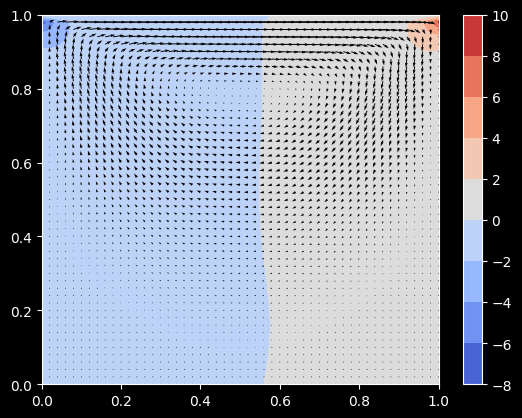

In [99]:
for _ in tqdm(range(N_ITERATIONS)):
    d_u_prev__d_x = central_difference_x(u_prev)
    d_u_prev__d_y = central_difference_y(u_prev)
    d_v_prev__d_x = central_difference_x(v_prev)
    d_v_prev__d_y = central_difference_y(v_prev)
    laplace__u_prev = laplace(u_prev)
    laplace__v_prev = laplace(v_prev)

    # Perform a tentative step by solving the momentum equation without the
    # pressure gradient
    u_tent = (
        u_prev
        +
        TIME_STEP_LENGTH * (
            -
            (
                u_prev * d_u_prev__d_x
                +
                v_prev * d_u_prev__d_y
            )
            +
            KINEMATIC_VISCOSITY * laplace__u_prev
        )
    )
    v_tent = (
        v_prev
        +
        TIME_STEP_LENGTH * (
            -
            (
                u_prev * d_v_prev__d_x
                +
                v_prev * d_v_prev__d_y
            )
            +
            KINEMATIC_VISCOSITY * laplace__v_prev
        )
    )

    # Velocity Boundary Conditions: Homogeneous Dirichlet BC everywhere
    # except for the horizontal velocity at the top, which is prescribed
    u_tent[0, :] = 0.0
    u_tent[:, 0] = 0.0
    u_tent[:, -1] = 0.0
    u_tent[-1, :] = HORIZONTAL_VELOCITY_TOP
    v_tent[0, :] = 0.0
    v_tent[:, 0] = 0.0
    v_tent[:, -1] = 0.0
    v_tent[-1, :] = 0.0


    d_u_tent__d_x = central_difference_x(u_tent)
    d_v_tent__d_y = central_difference_y(v_tent)

    # Compute a pressure correction by solving the pressure-poisson equation
    rhs = (
        DENSITY / TIME_STEP_LENGTH
        *
        (
            d_u_tent__d_x
            +
            d_v_tent__d_y
        )
    )

    for _ in range(N_PRESSURE_POISSON_ITERATIONS):
        p_next = np.zeros_like(p_prev)
        p_next[1:-1, 1:-1] = 1/4 * (
            +
            p_prev[1:-1, 0:-2]
            +
            p_prev[0:-2, 1:-1]
            +
            p_prev[1:-1, 2:  ]
            +
            p_prev[2:  , 1:-1]
            -
            element_length**2
            *
            rhs[1:-1, 1:-1]
        )

        # Pressure Boundary Conditions: Homogeneous Neumann Boundary
        # Conditions everywhere except for the top, where it is a
        # homogeneous Dirichlet BC
        p_next[:, -1] = p_next[:, -2]
        p_next[0,  :] = p_next[1,  :]
        p_next[:,  0] = p_next[:,  1]
        p_next[-1, :] = 0.0

        p_prev = p_next


    d_p_next__d_x = central_difference_x(p_next)
    d_p_next__d_y = central_difference_y(p_next)

    # Correct the velocities such that the fluid stays incompressible
    u_next = (
        u_tent
        -
        TIME_STEP_LENGTH / DENSITY
        *
        d_p_next__d_x
    )
    v_next = (
        v_tent
        -
        TIME_STEP_LENGTH / DENSITY
        *
        d_p_next__d_y
    )

    # Velocity Boundary Conditions: Homogeneous Dirichlet BC everywhere
    # except for the horizontal velocity at the top, which is prescribed
    u_next[0, :] = 0.0
    u_next[:, 0] = 0.0
    u_next[:, -1] = 0.0
    u_next[-1, :] = HORIZONTAL_VELOCITY_TOP
    v_next[0, :] = 0.0
    v_next[:, 0] = 0.0
    v_next[:, -1] = 0.0
    v_next[-1, :] = 0.0


    # Advance in time
    u_prev = u_next
    v_prev = v_next
    p_prev = p_next


# The [::2, ::2] selects only every second entry (less cluttering plot)
plt.style.use("dark_background")
plt.figure()
plt.contourf(X[::2, ::2], Y[::2, ::2], p_next[::2, ::2], cmap="coolwarm")
plt.colorbar()

plt.quiver(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
# plt.streamplot(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()